### 1. Datenvorbereitung  <a class="anchor" id=" 1. Datenvorbereitung"></a>

### 2. Deskriptive Analyse  <a class="anchor" id=" 2. Deskriptive Analyse"></a>

#### 2.1 Datenanalyse auf Tagesbasis <a class="anchor" id="Datenanalyse auf Tagesbasis "></a>
#### 2.2 Datenanalyse auf Monatsbasis <a class="anchor" id="Datenanalyse auf Monatsbasis"></a>
#### 2.3 Datenanalyse auf Jahresbasis <a class="anchor" id="Datenanalyse auf Jahresbasis"></a>

###  3. Komponentenmodell  <a class="anchor" id="3. Komponentenmodell"></a>

#### 3.1 Trendbreinigung  <a class="anchor" id="3.1 Trendbreinigung"></a>
#### 3.2 Saisonbereinigung  <a class="anchor" id="3.2 Saisonbereinigung"></a>

###  4. Stationarität  <a class="anchor" id=" 4. Stationarität"></a>

#### Section 2.1 <a class="anchor" id="section_2_1"></a>

#### Section 2.2 <a class="anchor" id="section_2_2"></a>
 
 
 
 4. Stationarität
    4.1 Visuelle Prüfung
    4.2 ADF-Test
    4.3 KPSS-Test
    4.4 Differenzenbildung
 5. ARMA Modellierung
 5.1 Betrachtung ACF 
#### 6. ARCH Modellierung

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SARIMAX
import csv

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from sklearn import linear_model
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches
import pylab
from math import sqrt
import statsmodels.api as sm
import seaborn as sns

# 1. Datenvorbereitung

In [3]:
  
serie_1 = pd.read_excel(r"Temp.xlsx", index_col=0)

Temp  = pd.DataFrame(serie_1)

print(Temp)


            TMK
MESS_DATUM     
1959-03-01  3.2
1959-03-02  1.0
1959-03-03  6.1
1959-03-04  7.2
1959-03-05  6.6
...         ...
2019-12-27  2.3
2019-12-28 -0.3
2019-12-29 -3.6
2019-12-30 -2.5
2019-12-31 -0.4

[22098 rows x 1 columns]


# 2. Deskriptive Analyse

## 2.1 Datenanalyse auf Tagesbasis

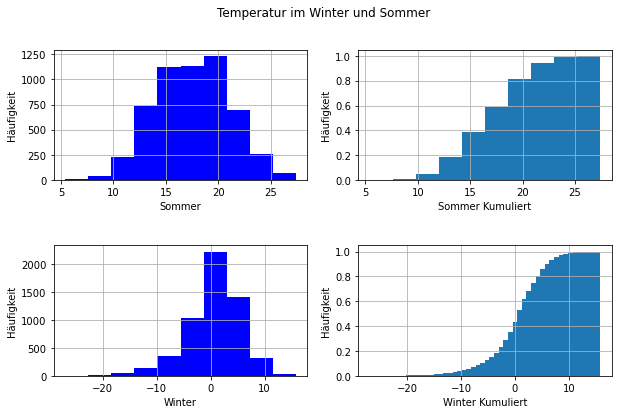

In [4]:

d_Temp = Temp.resample('D').mean()

def getMonths(ag,m1,m2,m3):
    a = ag[ag.index.month == m1]
    b = ag[ag.index.month == m2]
    c = ag[ag.index.month == m3]
    return pd.concat([a,b,c])

Summer = getMonths(d_Temp,6,7,8)
Winter = getMonths(d_Temp,11,12,1)

# 2.Visualisierung Temperatur im Sommer und Winter


plt.rcParams["figure.figsize"] = (10, 6)
fig, ax = plt.subplots(2, 2)
fig.suptitle('Temperatur im Winter und Sommer')

ax[0,0].hist(Summer, histtype = 'bar', facecolor = 'blue')
ax[0,0].set_xlabel('Sommer')
ax[0,0].set_ylabel('Häufigkeit')
ax[0,0].grid(True)

ax[1,0].hist(Winter, histtype = 'bar', facecolor = 'blue')
ax[1,0].set_xlabel('Winter')
ax[1,0].set_ylabel('Häufigkeit')
ax[1,0].grid(True)

ax[0,1].hist(Summer, density=True, cumulative=True)
ax[0,1].set_xlabel('Sommer Kumuliert')
ax[0,1].set_ylabel('Häufigkeit')
ax[0,1].grid(True)

ax[1,1].hist(Winter.iloc[:,0], 50, density=True, cumulative=True)
ax[1,1].set_xlabel('Winter Kumuliert')
ax[1,1].set_ylabel('Häufigkeit')
ax[1,1].grid(True)

fig.subplots_adjust(hspace=0.5)

plt.show()


### 2.1.1  Autokorrelation

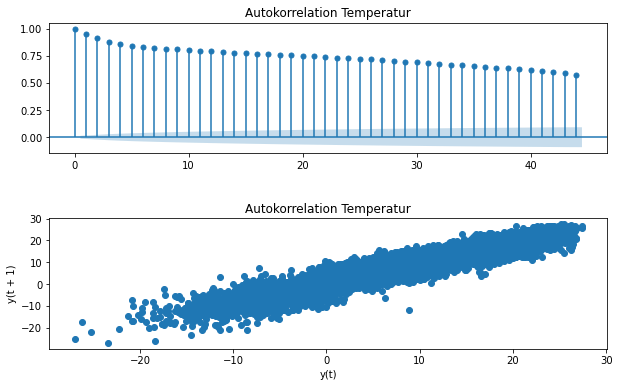

In [5]:

plt.rcParams["figure.figsize"] = (10, 6)

fig, (ax1, ax2) = plt.subplots(2)

plot_acf(Temp['TMK'], ax=ax1 )
ax1.set_title("Autokorrelation Temperatur")


lag_plot(Temp['TMK'], lag=1, ax=ax2)
ax2.set_title("Autokorrelation Temperatur")


fig.subplots_adjust(hspace=0.5)
plt.show()




### Interpretation

Sehr starke Korrelation zwischen t-1 und t, diese nimmt jedoch im Laufe der Zeit immer mehr ab.

## 2.1.2 HDD Berechnung



HDD Summenwerte pro Jahr 
 
                HDD
MESS_DATUM        
1959-12-31  1951.8
1960-12-31  3082.2
1961-12-31  2991.3
1962-12-31  3596.8
1963-12-31  3709.9
...            ...
2015-12-31  2546.1
2016-12-31  2669.8
2017-12-31  2755.0
2018-12-31  2370.4
2019-12-31  2500.3

[61 rows x 1 columns]


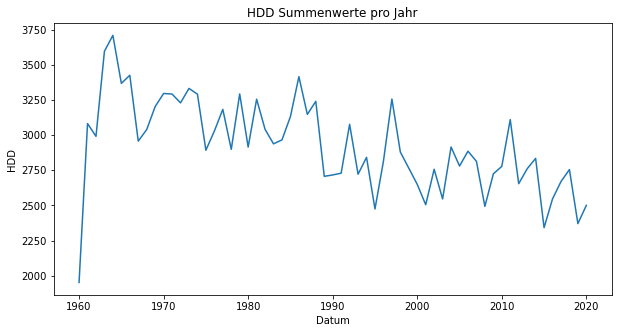

In [6]:

zeros_vect = np.zeros((Temp.shape))
HDD = np.maximum(zeros_vect, 16 - Temp)
HDD = pd.DataFrame(HDD)

# HDD Summenwerte pro Jahr

Sum_HDD = HDD.resample('Y').sum()
Sum_HDD.columns = ['HDD']
print('HDD Summenwerte pro Jahr \n \n',Sum_HDD)

# Visualisierung des HDDs

plt.rcParams["figure.figsize"] = (10, 5)
fig, (ax1) = plt.subplots(1,1)
ax1.plot(Sum_HDD.index.values,Sum_HDD)
ax1.set_title('HDD Summenwerte pro Jahr')
ax1.set_xlabel('Datum')
ax1.set_ylabel('HDD')
plt.show()


## 2.2 Datenanalyse auf Monatsbasis


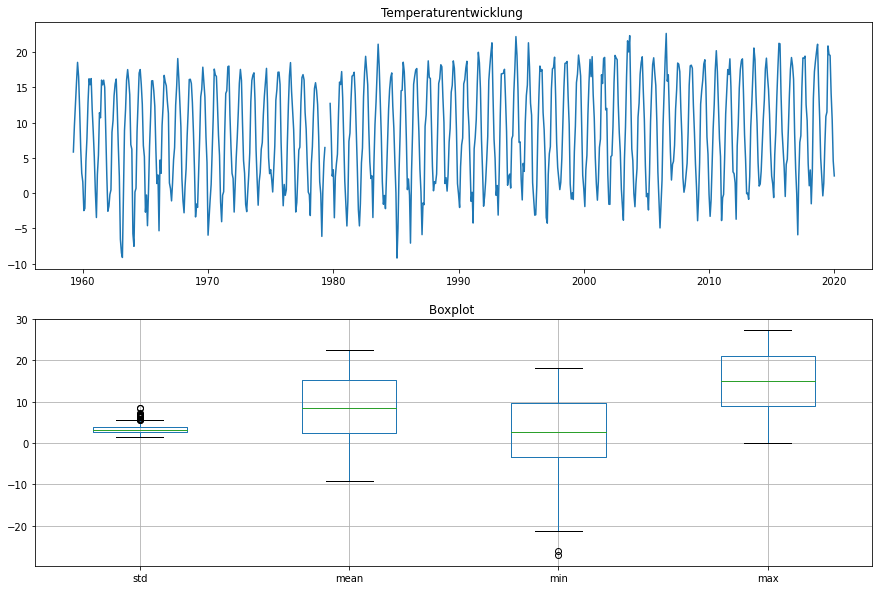

In [7]:
# Monatliche Aggregation von temperaturdaten

min_Temp = Temp.resample('M').min()
mean_Temp = Temp.resample('M').mean()
std_Temp = Temp.resample('M').std()
max_Temp = Temp.resample('M').max()

month_T = pd.concat([std_Temp,mean_Temp,min_Temp,max_Temp], axis = 1) 
month_T.columns = ['std','mean', 'min', 'max']


# Visualisierung Boxplot


def Box_plot(data1,data2):
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
    ax[0].set_title('Temperaturentwicklung ')
    ax[1].set_title('Boxplot ')    
    ax[0].plot(data1)
    data2.boxplot()
    plt.show()

Box_plot(month_T['mean'], month_T)





## 2.3 Datenanalyse auf Jahresbasis

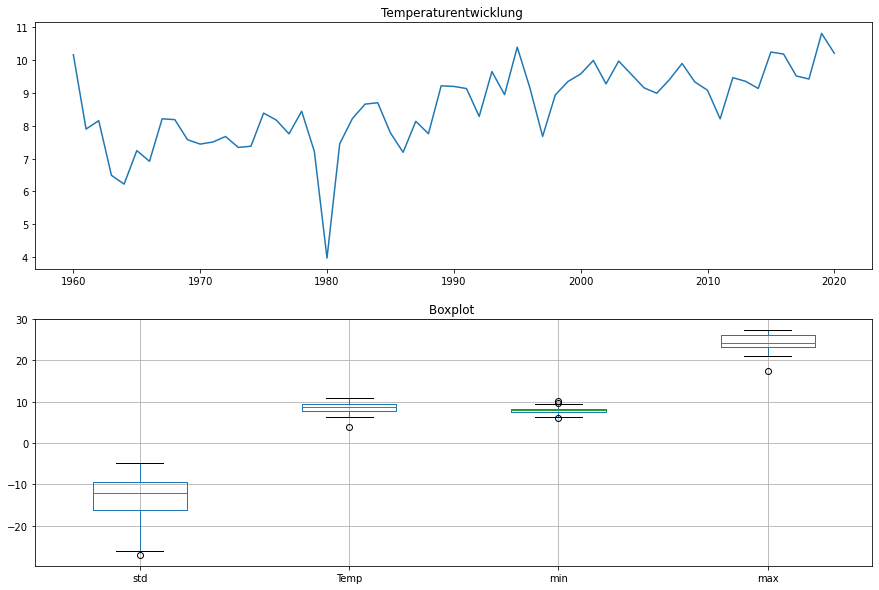

In [8]:
# Jahresanalyse

# Aggregation von Temperaturdaten

y_min_T = Temp.resample('Y').min()
y_mean_T = Temp.resample('Y').mean()
y_std_T = Temp.resample('Y').std()
y_max_T = Temp.resample('Y').max()

y_T = pd.concat([y_min_T.rename(columns={"TMK": "std"}),
                             y_mean_T.rename(columns={"TMK": "Temp"}),
                             y_std_T.rename(columns={"TMK": "min"}),
                             y_max_T.rename(columns={"TMK": "max"})], axis = 1)

# Datenvisualisierung

Box_plot(y_T['Temp'], y_T)





# 3. Komponentenmodell

## 3.1 Trendbreinigung

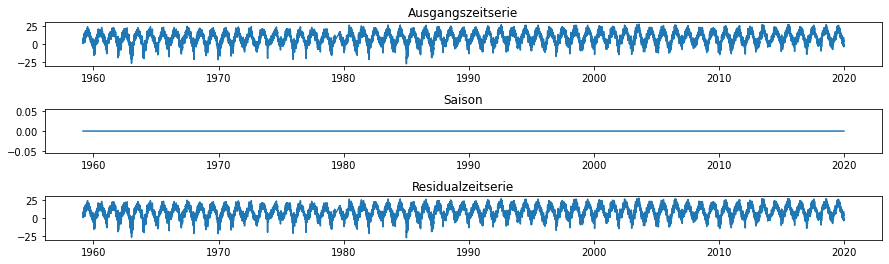

In [9]:
# Trenbereinigung Temperatur 

x = Temp.index.values
y = Temp['TMK']


# Visualisierung der Ausgangszeitreihe

plt.rcParams["figure.figsize"] = (15, 4)
fig1, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(x, y)
ax1.set_title('Ausgangszeitserie')
ax2.plot(x, np.zeros((x.shape)))
ax2.set_title('Saison')
ax3.plot(x,y - np.zeros((x.shape)))
ax3.set_title('Residualzeitserie')
fig1.subplots_adjust(hspace=1)
plt.show()


const    7.15177
x1       0.00013
dtype: float64


                             OLS Regression Results                            
Dep. Variable:                    TMK   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     239.6
Date:                Sun, 27 Feb 2022   Prob (F-statistic):           9.32e-54
Time:                        17:06:54   Log-Likelihood:                -77277.
No. Observations:               22098   AIC:                         1.546e+05
Df Residuals:                   22096   BIC:                         1.546e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


NameError: name 'x' is not defined

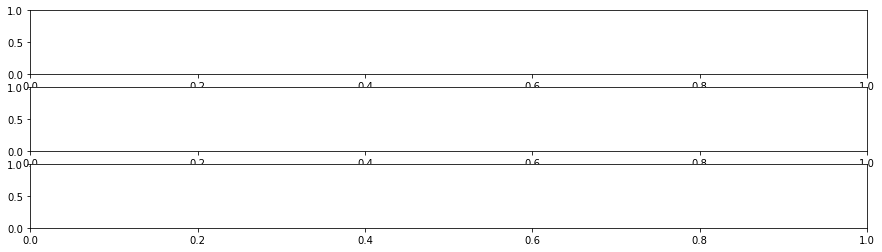

In [9]:
# Formulierung des Vektors X

X_1 = np.arange(Temp['TMK'].shape[0])  


# Regressionsmodell Temperatur

X_1 = sm.add_constant(X_1)
model_1 = sm.OLS(Temp['TMK'],X_1) 
result_1 = model_1.fit()
coeff = result_1.params
print(coeff)
print('\n\n', result_1.summary())
Temp['g'] = result_1.predict()
Temp['residuals'] = Temp['TMK'] - Temp['g']

# Visualisierung 

plt.rcParams["figure.figsize"] = (15, 4)
fig3, (ax1,ax2,ax3) = plt.subplots(3,1)
ax1.plot(x,y)
ax1.set_title('Ausgangszeitreihe')
ax2.plot(x, Temp['g'])
ax2.set_title('Trend')
ax3.plot(x,Temp['residuals'])
ax3.set_title('Resiudals')
fig3.subplots_adjust(hspace=1)

plt.show()

### 3.2 Saisonbereinigung

Im Rahmen der deskriptiven Analyse wurde eine Saisonalität im Datensatz festgestellt. Nach der Trendbereinigung soll auf dieser Erkenntnis im folgenden die Saisonalität aus dem Datensatz entfernt werden.

Das verwendete Modell enthält keine Konstante, da die Residuen der Trendbereingung verwendet wurden. 



                                  OLS Regression Results                                
Dep. Variable:              residuals   R-squared (uncentered):                   0.299
Model:                            OLS   Adj. R-squared (uncentered):              0.298
Method:                 Least Squares   F-statistic:                              1880.
Date:                Sun, 27 Feb 2022   Prob (F-statistic):                        0.00
Time:                        17:06:56   Log-Likelihood:                         -73359.
No. Observations:               22098   AIC:                                  1.467e+05
Df Residuals:                   22093   BIC:                                  1.468e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

NameError: name 'x' is not defined

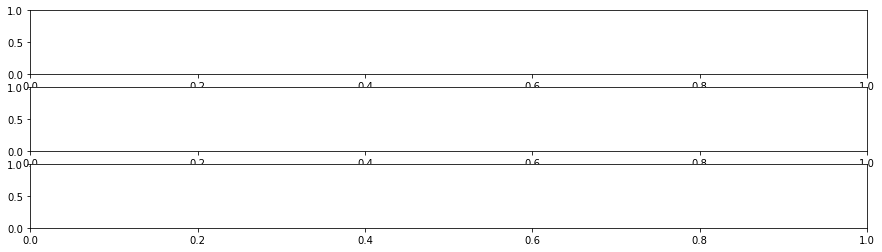

In [10]:
# Saisonbereinigung der Temperatur (Fourrier)


# Modellparametrierung

Asin = np.array([1, 2])
Bcos = np.array([1,2,3])
t = np.arange(Temp['residuals'].shape[0])
t = t.reshape(len(t),1)

# Aufbau der Regressoren
    
a = np.array([np.sin(Asin * 2 * np.pi * t/365)])
b = np.array([np.cos(Bcos * 2 * np.pi * t/365)])
X = np.concatenate((a, b), axis=2)
X = X[0]
    

# Regressionsmodell ohne Intercept

reg = sm.OLS(endog=Temp['residuals'], exog=X).fit()
params = reg.params
saison_coef1 = params[0]
saison_coef2 = params[1]
Temp['saison'] = np.dot(X,params) 
Temp['residuals_wt'] = Temp['residuals'] - (Temp['saison']) 
print('\n\n', reg.summary())


# Visualisierung

plt.rcParams["figure.figsize"] = (15, 4)
fig3, (ax1,ax2,ax3)=plt.subplots(3,1)
ax1.plot(x,y)
ax1.set_title('Ausgangszeitreihe')
ax2.plot(t,(Temp['saison'])) 
ax2.set_title('Saison')
ax3.plot(t,Temp['residuals_wt'])
ax3.set_title('Resiudals')
fig3.subplots_adjust(hspace=0.8)
plt.show()








# 4. Stationarität


## 4.1 Visuelle Prüfung

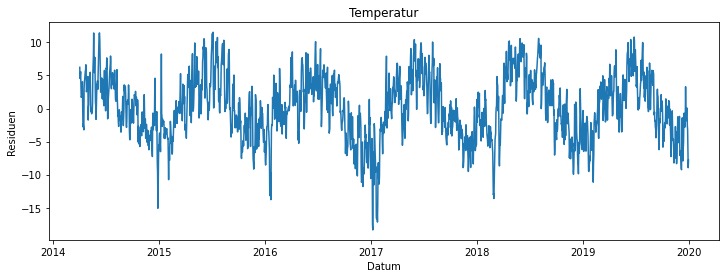

In [11]:

# Visuelle Prüfung von Temperatur 
     
plt.rcParams["figure.figsize"] = (12, 4)
fig, (ax1) = plt.subplots(1,1)
ax1.plot(Temp.index.values[20000:-1],Temp['residuals_wt'].iloc[20000:-1]) 
ax1.set_title('Temperatur')
ax1.set_xlabel('Datum')
ax1.set_ylabel('Residuen')

plt.show()




 ### Interpretation: 

Die Temperaturzeitreihen ist niveauabhängig, da die Streuung nach oben hin konstant bleibt. 


## 4.2 ADF-Test


Das Ziel des ADF-Tests ist es zu überprüfen, ob die Zeitreihe stationär ist. Das Signifikanzniveau des ADF-Tests lässt sich durch die p-value bestimmen und die H0-Hypothese wird verworfen, wenn p größer als 5% ist.

H0-Hypothese: die Zeitreihe ist nicht Stationär.

HA-Hypothese: die Zeitreihe ist Stationär.


In [12]:
# Temperatur

for i in range(1,10):
    
    result_ADF1 = adfuller(Temp['residuals_wt'].iloc[20000:-1].dropna(), maxlag=i*4)
    print('ADF Statistic TEMP: %f' % result_ADF1[0])
    print('p-value: %f' % result_ADF1[1])         
    print('Lags used: %d' % result_ADF1[2])


ADF Statistic TEMP: -7.921669
p-value: 0.000000
Lags used: 4
ADF Statistic TEMP: -6.335142
p-value: 0.000000
Lags used: 8
ADF Statistic TEMP: -4.850817
p-value: 0.000043
Lags used: 12
ADF Statistic TEMP: -4.210426
p-value: 0.000633
Lags used: 14
ADF Statistic TEMP: -3.639554
p-value: 0.005048
Lags used: 20
ADF Statistic TEMP: -3.639554
p-value: 0.005048
Lags used: 20
ADF Statistic TEMP: -3.639554
p-value: 0.005048
Lags used: 20
ADF Statistic TEMP: -3.639554
p-value: 0.005048
Lags used: 20
ADF Statistic TEMP: -3.639554
p-value: 0.005048
Lags used: 20


### Interpretation 
 
Der P-value ist bei den 5 Lags signifikant und die Zeitreihe ist damit nicht Stationät.

## 4.3 KPSS-Test

Der KPSS-Test ist ein Gegentest, der als Überprüfung des Ergibnisses des ADF-Tests dient, und ist als Rückversicherung für ein richtiges Ergebni anzusehen.

H0-Hypothese: die Zeitreihe ist stationär.


HA-Hypothese: die Zeitreihe ist nicht Stationär.




In [13]:
for i in range(1,10):
    
    result_KPSS1 = sm.tsa.stattools.kpss(Temp['residuals_wt'].iloc[20000:-1], regression='ct',nlags=i)
    print('KPSS test statistic TEMP: %f' % result_KPSS1[0])
    print('p-value: %f' % result_KPSS1[1]) 
    print('Lags used: %d' % result_KPSS1[2])


KPSS test statistic TEMP: 0.741422
p-value: 0.010000
Lags used: 1
KPSS test statistic TEMP: 0.516286
p-value: 0.010000
Lags used: 2
KPSS test statistic TEMP: 0.402163
p-value: 0.010000
Lags used: 3
KPSS test statistic TEMP: 0.332478
p-value: 0.010000
Lags used: 4
KPSS test statistic TEMP: 0.285167
p-value: 0.010000
Lags used: 5
KPSS test statistic TEMP: 0.250858
p-value: 0.010000
Lags used: 6
KPSS test statistic TEMP: 0.224744
p-value: 0.010000
Lags used: 7
KPSS test statistic TEMP: 0.204121
p-value: 0.014455
Lags used: 8
KPSS test statistic TEMP: 0.187364
p-value: 0.020739
Lags used: 9


C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is small

#### Interpretation 

Der Test wird mit einem Signifikanzniveau von 5% durchgeführt. Da der P-value bei allen geprüften Lags unter 5% liegt ist die H0-Hypothese zu verwerfen, die Temperaturzeitreihe ist auch nach dem KPSS-Test nicht stationär. 


## 4.4 Differenzenbildung




Wird nach der visuellen Prüfung und den statistischen Tests keine Aussage über die Zeit betreffende Varianz-Stationarität festgestellt, dann ist die Differenzenbildung zur Herstellung der Stationarität durchzuführen. Hierfür werden nach dem nachstehenden Muster die Differenzen der Zeitreihe gebildet: Y(t) = Y(t) - Y(t-1).


NameError: name 'x' is not defined

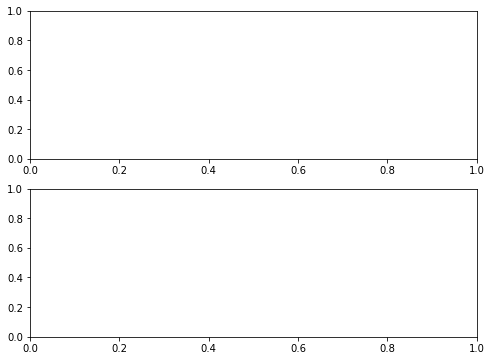

In [16]:
# Visualiserung

Temp_diff = Temp['residuals_wt'].diff().iloc[20000:-1]

plt.rcParams["figure.figsize"] = (8, 6)
fig, (ax1, ax2) = plt.subplots(2)

ax1.plot(x[20000:-1], Temp['residuals_wt'].iloc[20000:-1])
ax1.set_title('Temperatur') 
ax1.set_xlabel('Datum')
ax1.set_ylabel('Residuen')

ax2.plot(x[20000:-1], Temp_diff)
ax2.set_title('Erste Ordnung Differenzenbildung ') 
ax2.set_xlabel('Datum')
ax2.set_ylabel('Residuen')

fig.subplots_adjust(hspace=0.6)
plt.show()


# 5. ARMA-Modellierung


In diesem Abschnitt wird ein einfaches lineares Modell unter Verwendung der AR-  (Autoregressive) und MA- (Moving Average ) Prozessen konstruiert.
> Es ist wichtig darzustellen, ob die Entwicklung der Zeitreihen durch „sich selbst“ (AR-Prozess) oder durch vergangene Innovationen (MA-Prozess) erklärt wird. Auch eine Kombination beider Verfahren ist möglich (ARMA-Prozess)

> Rückschlüsse auf die bestmöglichen Parameter und die Struktur des  Modells sind durch eine visuelle Betrachtung der ACF und PACF der Zeitreihe aufzuzeigen.

> Der Abklingender und abfallender Verlauf der ACF und PACF gibt mögliche Hinweise auf die Auswahl des Modells.
Lags außerhalb des Konfidenzintervalls können Aussage über bestmögliche signifikanten Lags geben

> Der Abklingender und abfallender Verlauf der ACF und PACF gibt mögliche Hinweise auf die Auswahl des Modells.
Lags außerhalb des Konfidenzintervalls können Aussage über bestmögliche domonierte Lags geben

## 5.1 Betrachtung ACF 

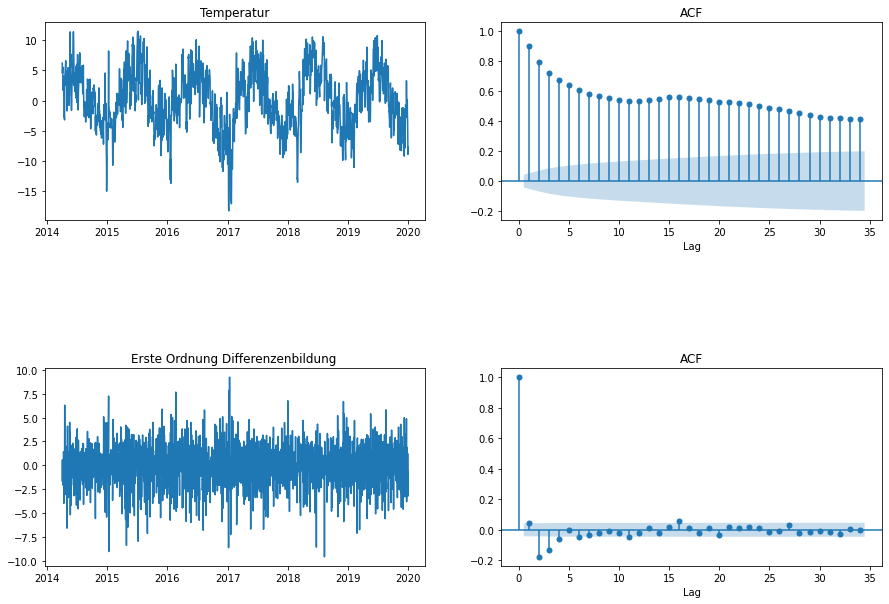

In [16]:
# Visualiserung (Temperatur)

plt.rcParams["figure.figsize"] = (15, 10)
fig, ax = plt.subplots(2,2)
ax[0,0].plot(x[20000:-1], Temp['residuals_wt'].iloc[20000:-1])
ax[0,0].set_title('Temperatur')
plot_acf(Temp['residuals_wt'].iloc[20000:-1], ax[0,1])
ax[0,1].set_title('ACF')
ax[0,1].set_xlabel('Lag')
ax[1,0].plot(x[20000:-1], Temp_diff)
ax[1,0].set_title('Erste Ordnung Differenzenbildung ') 
plot_acf(Temp_diff.dropna(),ax[1,1])
ax[1,1].set_title('ACF')
ax[1,1].set_xlabel('Lag')
plt.subplots_adjust(hspace=0.75)                              
plt.show()



Die ACF sinkt langsam für nicht-stationäre Zeitreihen, während diese für stationäre Zeitreihen sehr schnell abnimmt.

## 5.2 Betrachtung PACF

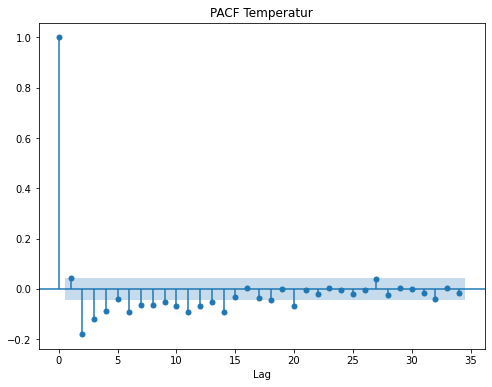

In [17]:
#Visualisierung

plt.rcParams["figure.figsize"] = (8, 6)
fig, (ax1) = plt.subplots(1,1)
plot_pacf(Temp_diff.dropna(), ax=ax1) 
ax1.set_title('PACF Temperatur')
ax1.set_xlabel('Lag')

plt.subplots_adjust(hspace=0.5)                              
plt.show()




#### Interpretation

Die Ordnung des AR-Prozesses ist mit Hilfe des PACF bestimmt. In der PACF-Abbildung des Temperaturprozesses wird AR(p) auf 0 gesetzt, da das einzig signifikante Lag bei 0 liegt. Gleiches gilt für den PACF, so dass MA(q) auch hier auf 0 gesetzt wird. Beim Gaspreisprozess ist der AR(p) mit 1 und der MA(q) mit 1 festgelegt.


>  Die ACF- und PACF-Plots sollten zusammen betrachtet werden, um den Prozess zu definieren. Für den AR-Prozess erwarten wir, dass der ACF-Plot einen abfallenden Verlauf hat und gleichzeitig der PACF einen starken Abkling nach p signifikanten Lags aufweisen sollte. Um einen MA-Prozess zu definieren, erwarten wir das Gegenteil von den ACF- und PACF-Diagrammen, was bedeutet, dass: das ACF klingt nach einer bestimmten Anzahl von q Lags ab, während das PACF einen geometrischen oder allmählich abnehmenden Trend zeigen sollte. Wenn andererseits sowohl ACF- als auch PACF-Plots ein allmählich abnehmendes Muster aufweisen, sollte der ARMA-Prozess für die Modellierung in Betracht gezogen werden.


## 5.3 Parametrierung des ARMA-Modells

In [18]:
# ARIMA Model Temperatur

model_temp = SARIMAX(Temp_diff.dropna(), order=(2,1,2))
fitted = model_temp.fit()

ARMA_Temp = pd.DataFrame(fitted.predict())
ARMA_Temp.columns = ['Yt']



#ARMA_Temp = pd.DataFrame(model_fit_t.predict())
print(fitted.summary())   


/Users/lailafdoul/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/lailafdoul/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19566D+00    |proj g|=  1.26359D-01

At iterate    5    f=  2.17239D+00    |proj g|=  2.18374D-02

At iterate   10    f=  2.16623D+00    |proj g|=  2.62059D-03

At iterate   15    f=  2.16600D+00    |proj g|=  1.32849D-03

At iterate   20    f=  2.16599D+00    |proj g|=  1.60795D-04

At iterate   25    f=  2.16599D+00    |proj g|=  3.37610D-04

At iterate   30    f=  2.16582D+00    |proj g|=  1.63865D-02

At iterate   35    f=  2.12378D+00    |proj g|=  4.56817D-02

At iterate   40    f=  2.12093D+00    |proj g|=  7.18518D-03

At iterate   45    f=  2.11966D+00    |proj g|=  1.79809D-03

At iterate   50    f=  2.11949D+00    |proj g|=  6.81726D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/lailafdoul/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Interpretation

#####Bei dem Temperaturprozess enthalten die Koeffizienten nur den konstanten Term und keine anderen Koeffizienten. Das liegt an den Werten p=0 und q=0, so dass keine vergangenen Werte und keine vergangenen Fehler in das Modell einfließen.

- p value (Coefficient)

## 5.4 Rückgabe der geschätzten Innovationen


In [19]:
# Temperatur

ARMA_Temp['residuals'] = pd.DataFrame(fitted.resid)
print(ARMA_Temp['residuals'])
print('Eingenschaften der geschätzten Innovationen des Temperaturprozesses:\n', ARMA_Temp['residuals'].describe())  



2014-04-04    0.515026
2014-04-05   -2.200741
2014-04-06    1.317449
2014-04-07    0.465042
2014-04-08   -1.882263
                ...   
2019-12-26   -2.034743
2019-12-27   -0.146116
2019-12-28   -2.593074
2019-12-29   -3.497782
2019-12-30    0.336463
Freq: D, Name: residuals, Length: 2097, dtype: float64
Eingenschaften der geschätzten Innovationen des Temperaturprozesses:
 count    2097.000000
mean        0.011830
std         2.016266
min        -9.210780
25%        -1.190408
50%         0.085544
75%         1.310196
max         8.996571
Name: residuals, dtype: float64


mean Interpretation

## 5.5 Visuelle Prüfung der Stationarität

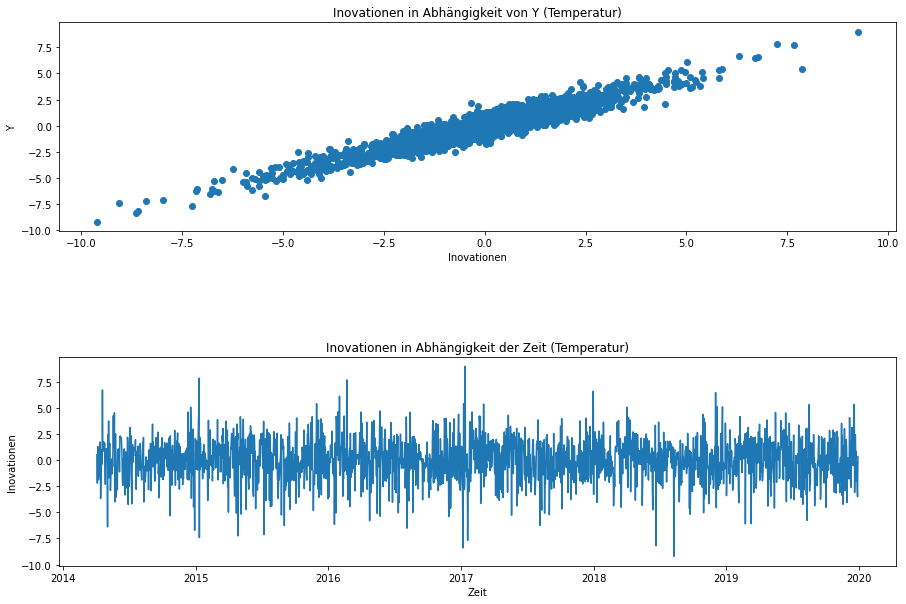

In [20]:

plt.rcParams["figure.figsize"] = (15, 10)
fig, (ax1, ax2) = plt.subplots(2)
ax1.scatter(Temp_diff.dropna(),ARMA_Temp['residuals'])
ax1.set_title('Inovationen in Abhängigkeit von Y (Temperatur)')
ax1.set_xlabel('Inovationen')
ax1.set_ylabel('Y')
ax2.plot(ARMA_Temp['residuals'])
ax2.set_title('Inovationen in Abhängigkeit der Zeit (Temperatur)')
ax2.set_xlabel('Zeit')
ax2.set_ylabel('Inovationen')
plt.subplots_adjust(hspace=0.6)
plt.show()


## 5.6 Prüfung der Unabhängigkeit

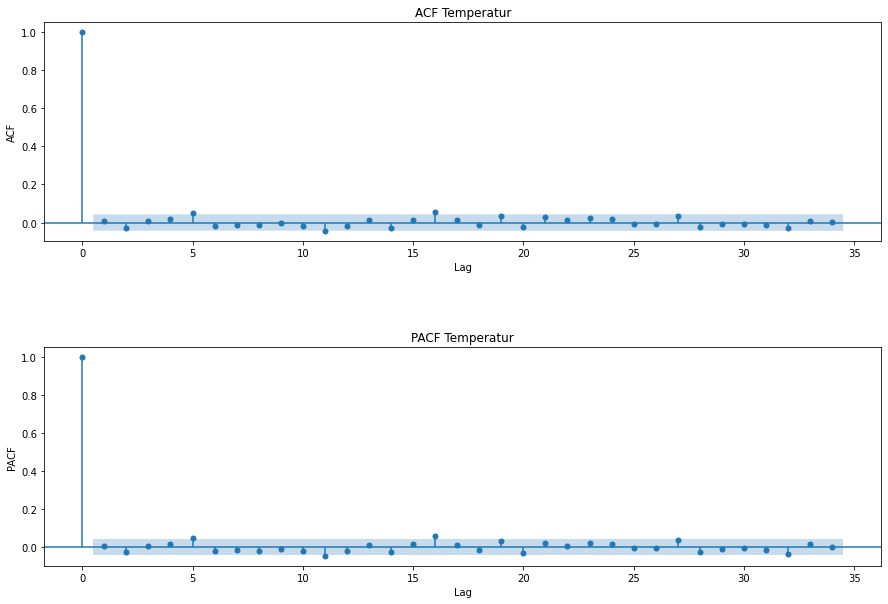

In [21]:
# ACF und PACF

plt.rcParams["figure.figsize"] = (15, 10)
fig, (ax1, ax2) = plt.subplots(2)
plot_acf(ARMA_Temp['residuals'].dropna(), ax=ax1)
ax1.set_title('ACF Temperatur')
ax1.set_ylabel('ACF')
ax1.set_xlabel('Lag')
plot_pacf(ARMA_Temp['residuals'].dropna(), ax=ax2)
ax2.set_title('PACF Temperatur')
ax2.set_ylabel('PACF')
ax2.set_xlabel('Lag')

fig.subplots_adjust(hspace=0.48)
plt.show()

## 5.7 Prüfung der Unabhängigkeit mithilfe des Ljung-Box-Tests

In [22]:
# Durchführung des Ljung-Box-Tests auf Temperaturresiduen mit Lag=1

sm.stats.acorr_ljungbox(ARMA_Temp['residuals'].dropna(), lags=[1], return_df=True)


,lb_stat,lb_pvalue
1,0.083743,0.772288


Bei dem Ljung-Box-Test werden die folgenden Hypothesen verwendet:

H0: Die Residuen sind unabhängig verteilt.

HA: Die Residuen sind nicht unabhängig verteilt, sie zeigen eine fortlaufende Korrelation.

Die Nullhypothese wird also beibehalten und die Residuen des Temperaturprozesses sind unabhängig verteilt.


## 5.8 Prüfung der Normalverteilung (Jarque Bera Test)

In [23]:
# Temperatur

stats.jarque_bera(ARMA_Temp['residuals'])

Jarque_beraResult(statistic=141.4372408117834, pvalue=0.0)

Der P-value des Jarque Bera Tests zeigt, dass die Nullhypothese nicht zurückgewiesen werden kann und dass die residuen normalverteilt sind

/Users/lailafdoul/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


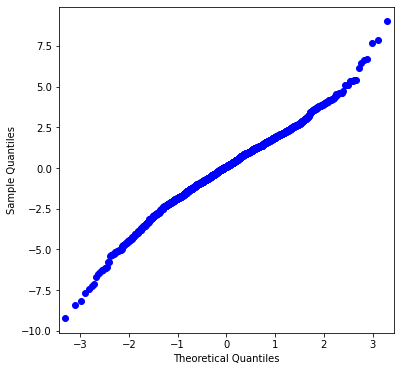

In [24]:
# Graphische überprÜfung der Normalverteilung mittels QQ-Plot

plt.rcParams["figure.figsize"] = (6, 6)
sm.qqplot(ARMA_Temp['residuals'].dropna())

plt.show()


# 6. GARCH Modellierung

Ziel: Überprüfung der Modellierungsfähigkeit der Zeitreihe durch ein ARCH/GARCH Modell 


## 6.1 Visuelle Prüfung

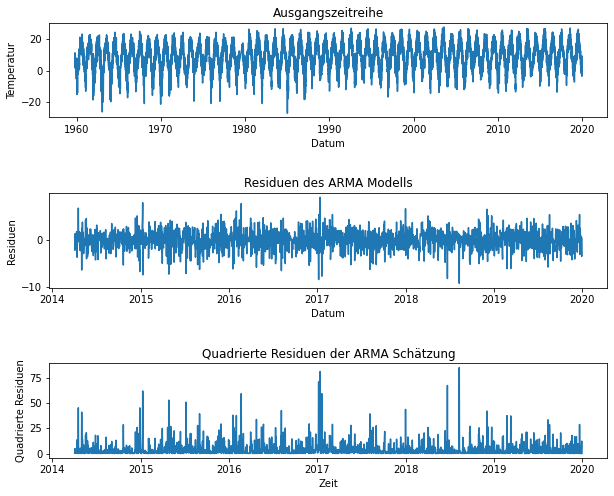

In [25]:

squared_resid1 = ARMA_Temp['residuals'].dropna() ** 2

# Visualisierung

plt.rcParams["figure.figsize"] = (10, 8)
fig, axes = plt.subplots(3,1)
axes[0].set_title('Ausgangszeitreihe')
axes[0].plot(x[220:-1],Temp['TMK'].iloc[220:-1])
axes[0].set_xlabel('Datum')
axes[0].set_ylabel('Temperatur')
axes[1].set_title('Residuen des ARMA Modells')
axes[1].plot(ARMA_Temp['residuals'].dropna())
axes[1].set_xlabel('Datum')
axes[1].set_ylabel('Residuen')
axes[2].set_title('Quadrierte Residuen der ARMA Schätzung')
axes[2].plot(squared_resid1)
axes[2].set_xlabel('Zeit')
axes[2].set_ylabel('Quadrierte Residuen')
fig.subplots_adjust(hspace=0.8)
plt.show()



## 6.2 ACF und PACF Analyse

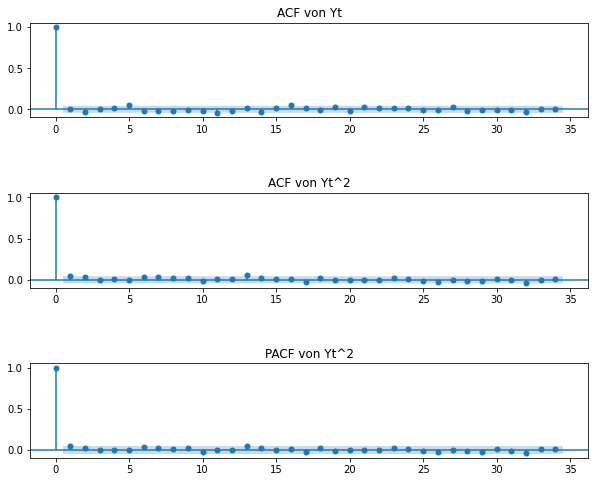

In [26]:
plt.rcParams["figure.figsize"] = (10, 8)
fig, axes = plt.subplots(3,1)
plot_acf(ARMA_Temp['residuals'], axes[0])
axes[0].set_title('ACF von Yt')
plot_acf(squared_resid1, axes[1])
axes[1].set_title('ACF von Yt^2')
plot_pacf(squared_resid1, axes[2])
axes[2].set_title('PACF von Yt^2')
fig.subplots_adjust(hspace=0.8)
plt.show()


Nach grafischer Überprüfung der quadrierten und unquadrierten ARMA Residuen, liegen klare Abhängigkeiten vor. Somit sind die geschätzten Innovationen nicht unabhängig.

#### Interpretation

Die ACF und PACF zeigen eine signifikante Autokorrelation in den quadrierten Restreihen.

## 6.3 Box Ljung Test

In [27]:
# Box Ljung Test zur Überprüfung der quardatischen Innovationen (Temperatur)

for i in range(1,10):
    
    lb_test1 = sm.stats.acorr_ljungbox(squared_resid1, lags=[i], return_df=True)
    print(lb_test1)
    
    



    lb_stat  lb_pvalue
1  4.549912    0.03292
    lb_stat  lb_pvalue
2  6.515222    0.03848
    lb_stat  lb_pvalue
3  6.530558   0.088465
    lb_stat  lb_pvalue
4  6.576195   0.160052
    lb_stat  lb_pvalue
5  6.602704   0.251903
    lb_stat  lb_pvalue
6  9.708973   0.137455
     lb_stat  lb_pvalue
7  11.748419   0.109142
     lb_stat  lb_pvalue
8  12.437287   0.132734
     lb_stat  lb_pvalue
9  13.536303   0.139802


Der Ljung-Box-Test wurde  durchgeführt, um Autokorrelation in den standardisierten Residuen festzustellen. 

Die Nullhypothese des Ljung-Box-Tests lautet: Die quadrierten residuen sind unabhängig verteilt. 

da der p-Wert größer als 0.05 ist, kann die Nullhypothese nicht verworfen werden. Es gibt somit keine eindeutigen Anzeichen für Autokorrelationen.


## 6.4 Engle ARCH Test zur Überprüfung von Heteroskedastizität


Das Ziel des Engle ARCH Tests besteht darin, das mögliche Vorhandensein von ARCH(Q)-Effekten (Heteroskedastizität) zu prüfen, bevor das ARCH-Modell geschätzt wird. Wenn kein ARCH-Effekt vorhanden ist, ist die Schätzung eines ARCH-Modells nicht erforderlich.

In [28]:
Engel_arch1 = het_arch(squared_resid1, maxlag=10)
print(f'Lagrange mulitplier p-value: {Engel_arch1[1]}')
print(f'F test p-value: {Engel_arch1[3]}')



Lagrange mulitplier p-value: 3.796509352098259e-06
F test p-value: 3.333314120203785e-06


/var/folders/mc/l1hbjbzx65b9_3ky1xk3xhd80000gn/T/ipykernel_3843/1336976469.py:1: FutureWarning: the 'maxlag'' keyword is deprecated, use 'nlags' instead
  Engel_arch1 = het_arch(squared_resid1, maxlag=10)


Die Nullhypothese des Lagrange Multiplier-Tests lautet, dass die Residuen keine ARCH-Effekte aufweisen. Die Alternativhypothese besagt, dass ARCH(lag)-Effekte vorhanden sind. Da der P-value im ARCH-Test von Engle signifikant ist, kann man davon ausgehen, dass die quadrierten Residuen ARCH-Effekte beinhalten.

## 6.5 Prüfung auf Saisonaler Volatilität

Ziel: Untersuchung des Vorliegens der jährlich saisonalen Volatilität durch die Darstellung der saisonalen Standardabweichung

In [29]:
# Gauß kernel:

#def GARCH_kernel(u):
    #x = 1/((2*np.pi)**2)*np.exp(-0.5*u*2)
    #return x


#GARCH_h1 = 0.25
#t = np.arange(resid_temp.shape[0])
#t = t.reshape(len(t),1)

#for i in range(1,len(t)+1):
    
    #a = abs(np.sin(2 * np.pi * t[:]/(2*365) - 2*np.pi*i/(2*365)))
    #temp_ARCH_u = a/GARCH_h1
    #temp_arch_std = sum(resid_temp **2 * GARCH_kernel(temp_ARCH_u)) ** 2 / sum(GARCH_kernel(temp_ARCH_u))
    
# Plot der Volatilität der Daten eines Jahres

#plt.plot(temp_arch_std, linewidth=2)
#plt.title('Volatilität der Daten')
#plt.xlabel('Tag im Jahr')
#plt.ylabel('Ausprägung')
#plt.grid()
#plt.show()

## 6.6 Schätzung des Modells



In [30]:
!pip install arch
from arch import arch_model

p_rng = range(1,4)
q_rng = range(2,6)

for p in p_rng:
    
        for q in q_rng:
            
            model_garch = arch_model(ARMA_Temp['residuals'].iloc[1:], mean = 'Constant', vol = 'GARCH', p=p, q=q)
            result_garch = model_garch.fit(update_freq = 10)
            print('GARCH ({}.{}): {}'.format(p,q, result_garch.summary()))
            GARCH_Temp = pd.DataFrame(result_garch.resid)
            GARCH_Temp.columns = ['Residuals']
            GARCH_Temp['STand_residuals'] = np.divide(GARCH_Temp['Residuals'], result_garch.conditional_volatility)

Iteration:     10,   Func. Count:     73,   Neg. LLF: 4437.935779172772
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4437.935731742036
            Iterations: 13
            Function evaluations: 90
            Gradient evaluations: 13
GARCH (1.2):                      Constant Mean - GARCH Model Results                      
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4437.94
Distribution:                  Normal   AIC:                           8885.87
Method:            Maximum Likelihood   BIC:                           8914.11
                                        No. Observations:                 2096
Date:                Sat, Feb 26 2022   Df Residuals:                     2095
Time:                        11:29:19   Df Model:                         

Iteration:     10,   Func. Count:     93,   Neg. LLF: 4437.5582685057825
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4437.541712337757
            Iterations: 16
            Function evaluations: 140
            Gradient evaluations: 16
GARCH (2.3):                      Constant Mean - GARCH Model Results                      
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4437.54
Distribution:                  Normal   AIC:                           8889.08
Method:            Maximum Likelihood   BIC:                           8928.62
                                        No. Observations:                 2096
Date:                Sat, Feb 26 2022   Df Residuals:                     2095
Time:                        11:29:19   Df Model:                       

Iteration:     10,   Func. Count:    103,   Neg. LLF: 4437.683982799052
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4437.541712500013
            Iterations: 18
            Function evaluations: 174
            Gradient evaluations: 18
GARCH (3.3):                      Constant Mean - GARCH Model Results                      
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4437.54
Distribution:                  Normal   AIC:                           8891.08
Method:            Maximum Likelihood   BIC:                           8936.27
                                        No. Observations:                 2096
Date:                Sat, Feb 26 2022   Df Residuals:                     2095
Time:                        11:29:20   Df Model:                        

## 6.7 Überprüfung der Eigenschaften der Residuen


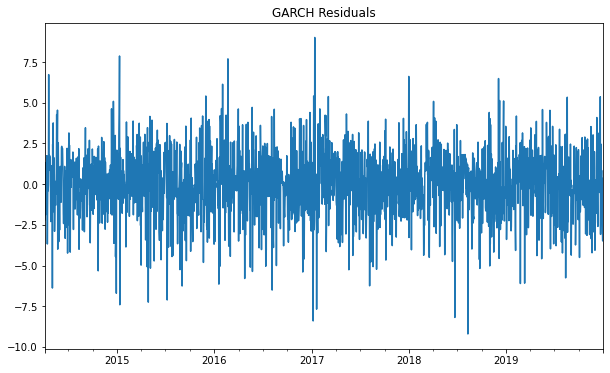

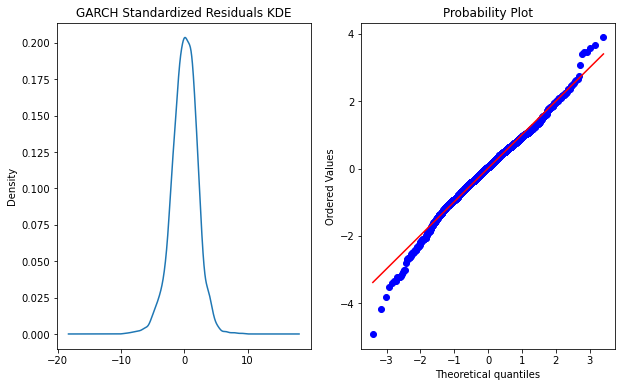

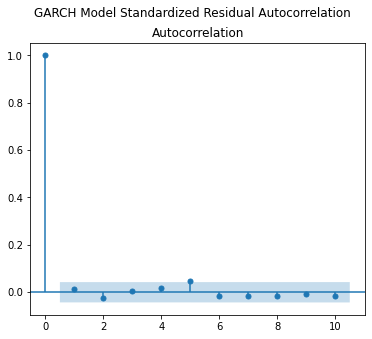

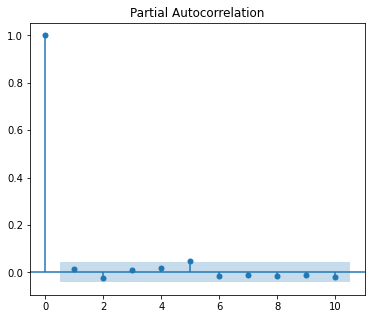

In [31]:
def resid_plot(residuals, stand_residuals, lags=10):
    
    residuals.plot(title='GARCH Residuals', figsize=(10, 6))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    ax[0].set_title('GARCH Standardized Residuals KDE')
    ax[1].set_title('GARCH Standardized Resduals Probability Plot')    
    residuals.plot(kind='kde', ax=ax[0])
    stats.probplot(stand_residuals, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(stand_residuals, lags=lags)
    pacf = plot_pacf(stand_residuals, lags=lags)
    acf.suptitle('GARCH Model Standardized Residual Autocorrelation', fontsize=12)
    acf.set_figheight(5)
    acf.set_figwidth(6)
    pacf.set_figheight(5)
    pacf.set_figwidth(6)
    plt.show()

resid_plot(GARCH_Temp['Residuals'], GARCH_['STand_residuals'])

## 6.8 Jarque Bera Test


The Jarque-Bera test is a type of lagrange multiplier test for normality. It usually used for large data sets because other normality tests are not reliable when n is large, Shapiro-Wilk isn't reliable with n more than 2,000. Jarque-Bera specifically mathces skewness and kurtosis to a normal distribution.

Ho
 : The data is normally distributed

Ha
 : The data does not come from a normal distribution

In [2]:
def model_evaluate(stand_residuals, lags=50):
    
    results = {'pvalue': None, 'statistic': None}
    
    Jarque_bera_test = stats.jarque_bera(stand_residuals)
    
    results['statistic'] = Jarque_bera_test[0]
    results['pvalue'] = Jarque_bera_test[1]
    
    if results['pvalue'] < 0.05:
        
        print('Nullhypothese wird abgelehnt. Die Residuen sind nicht normalverteilt')
        return results
    
    else:
        
        print('Nulllhypothese wird nicht abgelehnt. Die Residuen sind normalverteilt')
        return results

model_evaluate(GARCH_Preis['STand_residuals'])

NameError: name 'GARCH_Preis' is not defined

In [40]:
# Daten abspeichern


Temp.to_excel('/Users/lailafdoul/Desktop/EDA/Kompo_Temp.xls', index=False)
ARMA_Temp.to_excel('/Users/lailafdoul/Desktop/EDA/ARMA_Temp.xls', index=False)
GARCH_Temp.to_excel('/Users/lailafdoul/Desktop/EDA/GARCH_Temp.xls', index=False)

# Save the regression coefficients to a file for later use
print(saison_coef1,saison_coef2)
file1 = open('/Users/lailafdoul/Desktop/EDA/Coeff_Trend.xls', 'a')  
str_coeff = repr(coeff)
file1.write(str_coeff)
file1.close()
file2 = open('/Users/lailafdoul/Desktop/EDA/Coeff_Saison.xls', 'a')  
str_saicoeff1 = repr(saison_coef1)
file2.write(str_saicoeff1)
str_saicoeff2 = repr(saison_coef2)
file2.write(str_saicoeff2)
file2.close()






/var/folders/mc/l1hbjbzx65b9_3ky1xk3xhd80000gn/T/ipykernel_3843/3572237994.py:4: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  Temp.to_excel('/Users/lailafdoul/Desktop/EDA/Kompo_Temp.xls', index=False)


4.871596021656086 0.11684290496679786


/var/folders/mc/l1hbjbzx65b9_3ky1xk3xhd80000gn/T/ipykernel_3843/3572237994.py:5: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  ARMA_Temp.to_excel('/Users/lailafdoul/Desktop/EDA/ARMA_Temp.xls', index=False)
/var/folders/mc/l1hbjbzx65b9_3ky1xk3xhd80000gn/T/ipykernel_3843/3572237994.py:6: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence t